In [ ]:
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time

%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [ ]:
url_labels_train = './data/BDD_data/labels/bdd100k_labels_images_train.json'
url_images_train = './data/BDD_data/bdd100k_images/bdd100k/images/100k/train/'
url_drivable_train = './data/BDD_data/drivable_maps/color_labels/train/'

url_labels_val = './data/BDD_data/labels/bdd100k_labels_images_val.json'
url_images_val = './data/BDD_data/bdd100k_images/bdd100k/images/100k/val/'
url_drivable_val = './data/BDD_data/drivable_maps/color_labels/val/'

prpro_url_img_train = './data/BDD_data/drivable_maps_preprocced/120x160/image_train/'
prpro_url_dri_train = './data/BDD_data/drivable_maps_preprocced/120x160/drivable_train/'

prpro_url_img_val = './data/BDD_data/drivable_maps_preprocced/120x160/image_val/'
prpro_url_dri_val = './data/BDD_data/drivable_maps_preprocced/120x160/drivable_val/'



drivable_ending = '_drivable_color.png'

IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 2
#_drivable_id.png
#_drivable_color.png

In [ ]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)
#tf.config.experimental.set_visible_devices(devices= gpus, device_type='GPU')
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
#tf.test.is_built_with_cuda()

#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
from tensorflow.python.client import device_lib

tf.test.gpu_device_name()


In [ ]:
#labels_train = pd.DataFrame({'img_name': json_labels_train.get('name')})

In [ ]:
print(datetime.now())
labels_train = pd.read_json(url_labels_train, orient='columns')
labels_val = pd.read_json(url_labels_val, orient='columns')
print(datetime.now())

In [ ]:
labels_train.head(3)

In [ ]:
train_img_ids = labels_train['name'].tolist()
val_img_ids = labels_val['name'].tolist()


#train_sun_ids = labels_train.loc[(labels_train['attributes'].get('weather') == 'clear') & (labels_train['attributes'].get('timeofday') == 'daytime') & (labels_train['attributes'].get('scene') == 'highway')]
#val_sun_ids = labels_val.loc[labels_val['attributes'].get('weather') == 'clear' & labels_val['attributes'].get('timeofday') == 'daytime' & labels_val['attributes'].get('scene') == 'highway']

In [127]:
def show_img(url):
    sample_img = mpimg.imread(sample_img_url)
    plt.imshow(sample_img)

def id_on_attribute(df, weather, timeofday, scene):
    train_cdh_ids = df.loc[(df['attributes'] == {'weather':weather,'timeofday':timeofday, 'scene':scene})]
    return train_cdh_ids['name'].tolist()
    
def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)
    a.set_title(title2)
    
def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 
    
def create_img_path(base, name):
    return base + name

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def rb_to_rgb(img):
    r, b = cv2.split(img)
    rgb_img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
    rgb_img[..., 0] = (r > 0.4).astype(np.uint8)
    rgb_img[..., 1] = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    rgb_img[..., 2] = (b > 0.4).astype(np.uint8)
    return rgb_img

def zoom(image, mask):
    zoom = iaa.Affine(scale=(1, 1.3))
    zoom.to_deterministic()
    image = zoom.augment_image(image)
    mask = zoom.augment_image(mask)
    return image, mask
    
def pan(image, mask):
    
    #aug_det = aug.to_deterministic()
    #image_aug = aug_det.augment_image(image)  # augment image
    #segmap_aug = aug_det.augment_segmentation_maps(segmap) 
    
    pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    pan = pan.to_deterministic()
    image = pan.augment_image(image)
    mask = pan.augment_image(mask)
    return image, mask

def img_random_brightness(image, mask):
    bri = iaa.Multiply((0.5, 1.1))
    image = bri.augment_image(image)
    #mask = bri.augment_image(mask)
    return image, mask 

def img_random_flip(image, mask):
    image = cv2.flip(image, 1)
    mask = cv2.flip(mask, 1)
    return image, mask
'''
def random_augment(image, mask):
    #image = mpimg.imread(image)
    
    if np.random.rand() < 1:
        image, mask = pan(image, mask)
    
    if np.random.rand() < 0.5:
        image, mask = zoom(image, mask)
    
    if np.random.rand() < 0.5:
        image, mask = img_random_brightness(image, mask)
    
    if np.random.rand() < 0.5:
        image, mask = img_random_flip(image, mask)
        
    #image = cv2.normalize(image, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = cv2.normalize(mask, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    return image, mask


'''   

def random_augment(img, mask):
    
    #if np.random.rand() < 0.5:
    #    img, mask = img_random_flip(img, mask)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Multiply((0.90, 1.10)),
        iaa.Dropout([0.0, 0.2]),
        iaa.Add((-40, 40)),
        iaa.Superpixels(p_replace=0.5, n_segments=64),
        iaa.Affine(
            scale=(1, 1.3),
            translate_percent=(-0.1, 0.1),
            rotate=(-15, 15),
            shear=(-2, 2))
        
    ])
    
    mask = cv2.normalize(mask, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)    
    #mask = np.uint8(np.where(mask > 0, 1, 0))
    
    segmap = SegmentationMapsOnImage(mask, shape=img.shape)
    
    img_aug, mask = seq(image=img, segmentation_maps=segmap)
    mask = mask.draw([IMG_HEIGHT, IMG_WIDTH, 3], colors=[(0, 0, 0), (255, 0, 0), (0, 0, 255)])
    c1, _, _ = cv2.split(mask[0])
    c2, _, _ = cv2.split(mask[2])
    
    rb_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 2), dtype=np.uint8)
    rb_mask[..., 0] = c1
    rb_mask[..., 1] = c2
    
    return img_aug, rb_mask
    
   
    

In [152]:
def batch_generator(image_paths, drivable_path, images_ids ,batch_size, index=0, training=True):
    
    
    index = index
    
    
    
    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(images_ids)
        
        for i in range(batch_size):
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
            
            #random_num = random.randint(0, data_size - 1)
            sample_img_url = image_paths + images_ids[index]
            sample_drivable_url = drivable_path + images_ids[index][:-4] + drivable_ending
            
           
            
            
            img = cv2.imread(sample_img_url)
            mask = cv2.imread(sample_drivable_url)
            
            img = img_process(img)
            mask = img_process(mask)
            
            
            if training:
                img, rb_mask = random_augment(img, mask)
                
            else: 
                #mask = np.array(mask) 
                b, g, r = cv2.split(mask) 

                rb_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 2))
                rb_mask[..., 0] = b
                rb_mask[..., 1] = r
                rb_mask = cv2.normalize(rb_mask, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)   
                
            img = cv2.normalize(img, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
            rb_mask = np.uint8(np.where(rb_mask > 0, 1, 0))
            
            images.append(img)
            maskes.append(rb_mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

## Testing functions

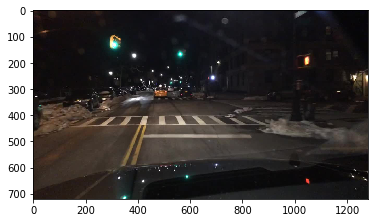

In [129]:
sample_label = labels_train.sample()
amount_data = labels_train.size
#sample_drivable = labels_drivable.sample()
random_num = random.randint(0, len(val_img_ids) - 1)


sample_img_url = create_img_path(url_images_val, val_img_ids[random_num])
sample_drivable_url = create_img_path(url_drivable_val, val_img_ids[random_num])[:-4] + drivable_ending

show_img(sample_drivable_url)

'\ninfo = np.iinfo(data.dtype) # Get the information of the incoming image type\ndata = data.astype(np.float64) / info.max # normalize the data to 0 - 1\ndata = 255 * data # Now scale by 255\nimg = data.astype(np.uint8)\n'

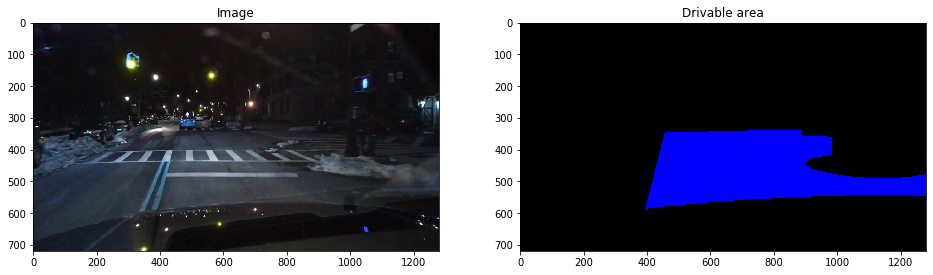

In [130]:
img1 = cv2.imread(sample_img_url, 1 )


#img2 = np.uint8(mpimg.imread(sample_drivable_url))
img2 = cv2.imread(sample_drivable_url, 1)

#info = np.iinfo(img2.dtype)
#img2 = img2.astype(np.float64) / info.max
#img2 = 255 * img2 # Now scale by 255
#img2 = np.uint8(img2)


compare_img(img1, img2, 'Image', 'Drivable area')
'''
info = np.iinfo(data.dtype) # Get the information of the incoming image type
data = data.astype(np.float64) / info.max # normalize the data to 0 - 1
data = 255 * data # Now scale by 255
img = data.astype(np.uint8)
'''


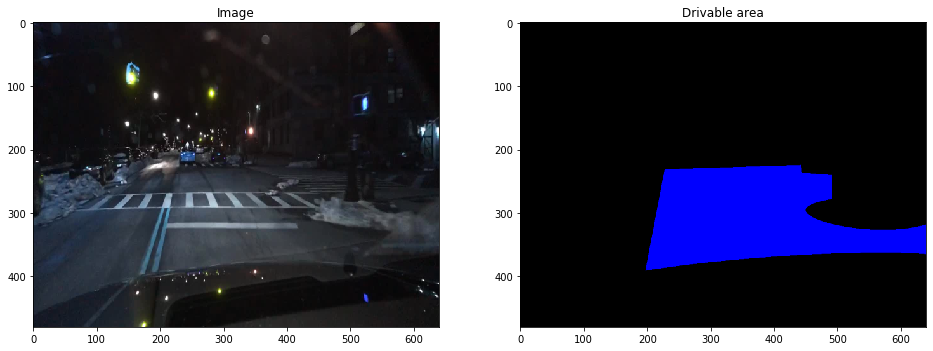

In [131]:
img1_resize = img_process(img1)
img2_resize = img_process(img2)
#img1_resize = cv2.normalize(img1_resize, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
#img2_resize = cv2.normalize(img2_resize, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
compare_img(img1_resize, img2_resize, 'Image', 'Drivable area')

image shape: (480, 640, 3), dtype: uint8
image shape: (480, 640, 3), dtype: uint8
aug img shape: (480, 640, 3), dtype: uint8
aug img shape: (480, 640, 3), dtype: uint8


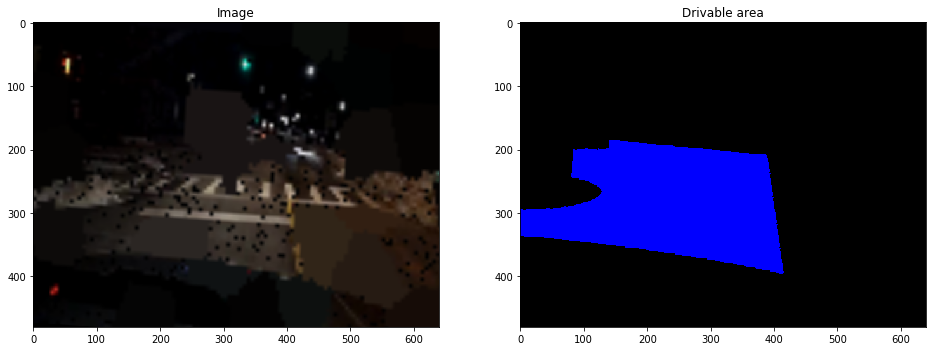

In [132]:
print(f'image shape: {img1_resize.shape}, dtype: {img1_resize.dtype}')
print(f'image shape: {img2_resize.shape}, dtype: {img2_resize.dtype}')

#img_2, _ = pan(img, mask)
img, mask = random_augment(img1_resize, img2_resize)
mask = rb_to_rgb(mask)

print(f'aug img shape: {img.shape}, dtype: {img.dtype}')
print(f'aug img shape: {mask.shape}, dtype: {mask.dtype}')


compare_img(img, mask*255, 'Image', 'Drivable area')

In [133]:
#x_train_gen, y_train_gen = next(batch_generator(prpro_url_img_train, prpro_url_dri_train, train_img_ids, 1))
#x_train_val, y_train_val = next(batch_generator(prpro_url_img_val, prpro_url_dri_val, val_img_ids, 1))

x_train_gen, y_train_gen = next(batch_generator(url_images_train, url_drivable_train, train_img_ids, 1))
x_train_val, y_train_val = next(batch_generator(url_images_val, url_drivable_val, val_img_ids, 1, index=10))

In [134]:
#compare_img(y_train_gen[0]*255, rb_to_rgb(y_train_val[0])*255, 'Image (x_train_gen)', 'trainable area (y_train_gen)')



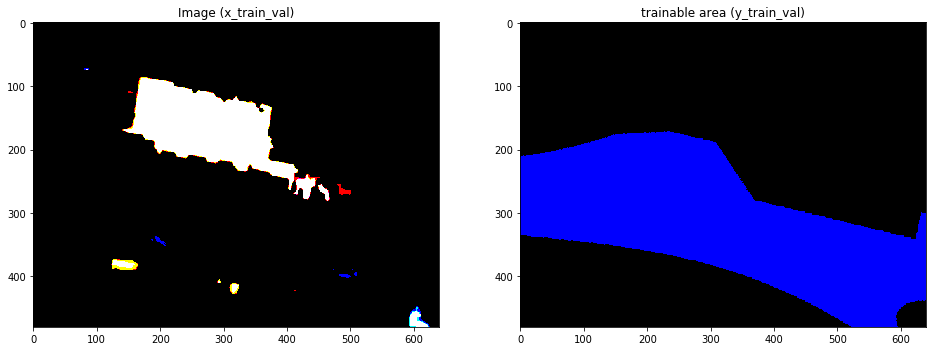

In [135]:
image = cv2.normalize(x_train_val[0], None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
mask = cv2.normalize(rb_to_rgb(y_train_val[0]), None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
compare_img(image,mask , 'Image (x_train_val)', 'trainable area (y_train_val)')

In [136]:
print('Train shape')
print(f'shapes x: {x_train_gen.shape},shapes y {y_train_gen.shape}')
print(f'shapes x: {x_train_val.shape}, shapes y {y_train_val.shape}')

Train shape
shapes x: (1, 480, 640, 3),shapes y (1, 480, 640, 2)
shapes x: (1, 480, 640, 3), shapes y (1, 480, 640, 2)


## Model info 

Cellen under inneholder informasjon om modelen, som skal srkives inn i json. 

In [137]:
def create_setup(labels_train, labels_val, arc, num_var=1):
    ids_train = []
    ids_val = []
    architecture = arc
    created = round(time.time())
    
    weather_list = ['rainy', 'snowy', 'clear', 'overcast', 'undefined', 'partly cloudy', 'foggy']
    scene_list =  ['tunnel', 'residential', 'parking lot', 'undefined', 'city street', 'gas stations', 'highway']
    timeofday_list = ['daytime', 'night', 'dawn/dusk', 'undefined']
    
    training_time = 0
    
    model_info = {}
    name = f'{architecture}_{created}.h5'
    
    model_info[name] = {
        'created': created, 
        'weather': [],
        'timeofday': [],
        'scene': [], 
        'training_time': 0,
        'data_amount': 0,
        'architecture': arc,
        'notes': 'no modification'
    }
    
    for i in range(num_var):
        weather = random.choice(weather_list)
        scene = random.choice(scene_list)
        timeofday = random.choice(timeofday_list)
        
        ids_train += id_on_attribute(labels_train, weather, 'night', scene)
        ids_val += id_on_attribute(labels_val, weather, 'night', scene)
        
        model_info[name]['weather'].append(weather)
        model_info[name]['scene'].append(scene)
        model_info[name]['timeofday'].append(timeofday)
    
    
    
    return ids_train, ids_val, model_info, name
    
    

def save_model(model, name, model_info):
    model.save(f'seg_models/{name}.h5')

    json_file_name = 'model_info.json'

    with open(json_file_name, 'r') as file_reader:
        model_data = json.load(file_reader)

    model_data.update(model_info)
    file_reader.close()

    with open(json_file_name, "w") as file_write:
    # write json data into file
        json.dump(model_data, file_write)
    file_write.close() 
    


#architecture='U-Net'



## Architecutre

In [149]:


activation = 'relu'

img_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))#640x480, 320x240

conv1 = Conv2D(64, (3, 3), activation=activation, padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(64, (3, 3), activation=activation, padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation=activation, padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(128, (3, 3), activation=activation, padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation=activation, padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(256, (3, 3), activation=activation, padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation=activation, padding='same')(pool3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(512, (3, 3), activation=activation, padding='same')(conv4)

up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
conv5 = Conv2D(256, (3, 3), activation=activation, padding='same')(up1)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(256, (3, 3), activation=activation, padding='same')(conv5)

up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
conv6 = Conv2D(128, (3, 3), activation=activation, padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(128, (3, 3), activation=activation, padding='same')(conv6)


up3 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
conv7 = Conv2D(64, (3, 3), activation=activation, padding='same')(up3)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(32, (3, 3), activation=activation, padding='same')(conv7)

out = Conv2D(NUM_SEG, (1,1), padding='same', activation='sigmoid')(conv7)

model = Model(inputs=[img_input], outputs=[out])

optimizer = Adam(lr=1e-3) #10 epocher er bra på -3
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])#'accuracy'

In [150]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 480, 640, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 480, 640, 64) 0           conv2d_75[0][0]                  
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 480, 640, 64) 36928       dropout_35[0][0]                 
____________________________________________________________________________________________

## Training 


In [153]:

#model = load_model('model_test_haug.h5')
NUM_MODELS = 1 
#model.load_weights('model_weight.ckpt')
for i in range(NUM_MODELS):
    ids_train, ids_val, model_info, model_name = create_setup(labels_train, labels_val, 'U-Net', 5)
    #print(ids_train)
    print(f'data size {len(ids_train)}')
   # print(ids_train)

    
    amount_data = len(ids_train)
    batch_size = 1 #32 er bra uten bremser
    stp = ((amount_data) // batch_size)
    
    if amount_data < 10:
        continue
        
    if stp < 500:
        stp = 500
        
    # prpro_url_img_train, prpro_url_dri_train
    # prpro_url_img_val, prpro_url_dri_val

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint_weight.ckpt', save_weights_only=True,verbose=1)

    start_time = time.time()
    
    print()
    print()
    print(f'training {i + 1} of {NUM_MODELS} models')
    print()
    print()

    history = model.fit(batch_generator(url_images_train, url_drivable_train, ids_train, batch_size), 
                                  steps_per_epoch= stp, #stp
                                  epochs=15, #10 hvirker mer en nokk
                                  validation_data=batch_generator(url_images_val, url_drivable_val, ids_val, 1, training= False), #100
                                  validation_steps=stp//10, # 200
                                  verbose=1,
                                  #callbacks=[cp_callback],
                                  use_multiprocessing=True)

    time_used = time.time() - start_time
    model_info[model_name]['training_time'] = time_used
    model_info[model_name]['data_amount'] = amount_data
    save_model(model, model_name, model_info)
    
    


data size 392


training 1 of 1 models


Epoch 1/15
500/500 [==============================] - 110s 219ms/step - loss: 0.2484 - mean_io_u_5: 0.4599 - val_loss: 0.2462 - val_mean_io_u_5: 0.4586
Epoch 2/15
500/500 [==============================] - 109s 217ms/step - loss: 0.2475 - mean_io_u_5: 0.4591 - val_loss: 0.2390 - val_mean_io_u_5: 0.4586
Epoch 3/15
500/500 [==============================] - 110s 220ms/step - loss: 0.2495 - mean_io_u_5: 0.4592 - val_loss: 0.2382 - val_mean_io_u_5: 0.4586
Epoch 4/15
500/500 [==============================] - 110s 220ms/step - loss: 0.2440 - mean_io_u_5: 0.4594 - val_loss: 0.2429 - val_mean_io_u_5: 0.4586
Epoch 5/15
500/500 [==============================] - 110s 221ms/step - loss: 0.2461 - mean_io_u_5: 0.4600 - val_loss: 0.2396 - val_mean_io_u_5: 0.4586
Epoch 6/15
500/500 [==============================] - 111s 221ms/step - loss: 0.2454 - mean_io_u_5: 0.4597 - val_loss: 0.2410 - val_mean_io_u_5: 0.4586
Epoch 7/15
500/500 [===========================

Text(0.5, 0, 'Epoch')

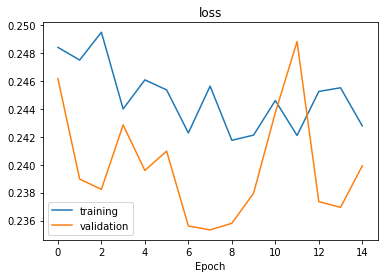

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('Epoch')


In [147]:
plt.plot(history.history['mean_io_u_3'])
plt.plot(history.history['val_mean_io_u_3'])
plt.legend(['training', 'validation'])
plt.title('Acuracy')
plt.xlabel('Epoch')

KeyError: 'mean_io_u_3'

In [117]:
def img_pre_tes(index):
    x_train_val, y_train_val = next(batch_generator(url_images_val, url_drivable_val, ids_val, 1,index=index, training= False))

    img_predicted = model.predict(x_train_val)
    img_predicted = rb_to_rgb(img_predicted[0])
    img_y = rb_to_rgb(y_train_val[0])
    #print(img_test[0].shape)

    img_predicted_mask = show_seg_on_img(x_train_val[0], img_predicted)
    img_mask = show_seg_on_img(x_train_val[0], img_y)
    compare_img(img_predicted_mask, img_mask, 'Prediction', 'Goal')
    compare_img(img_predicted*255, img_y*255, 'Prediction', 'Goal')

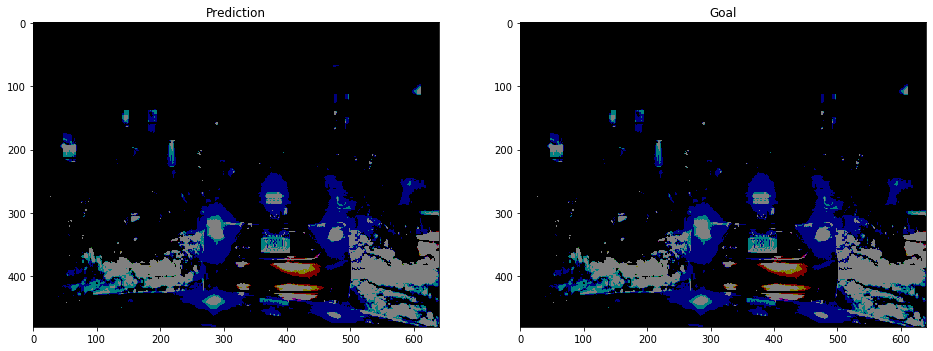

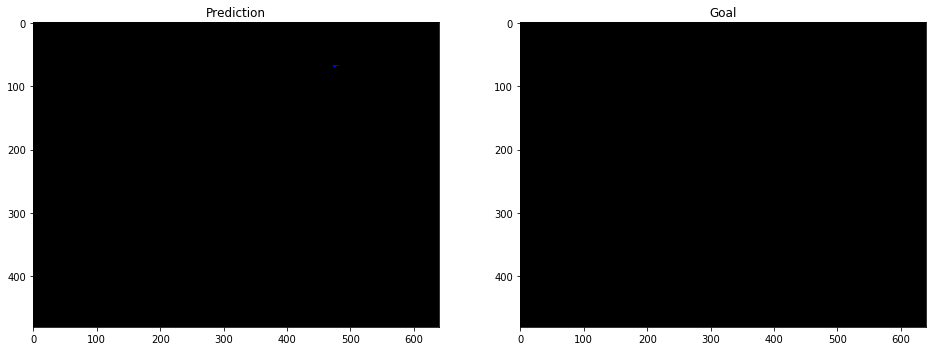

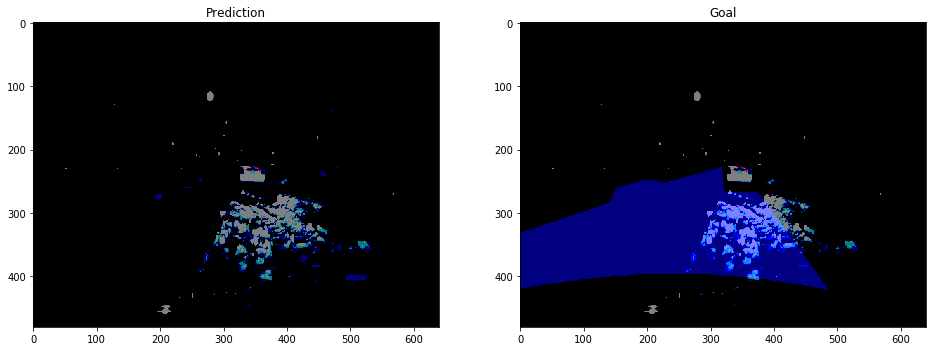

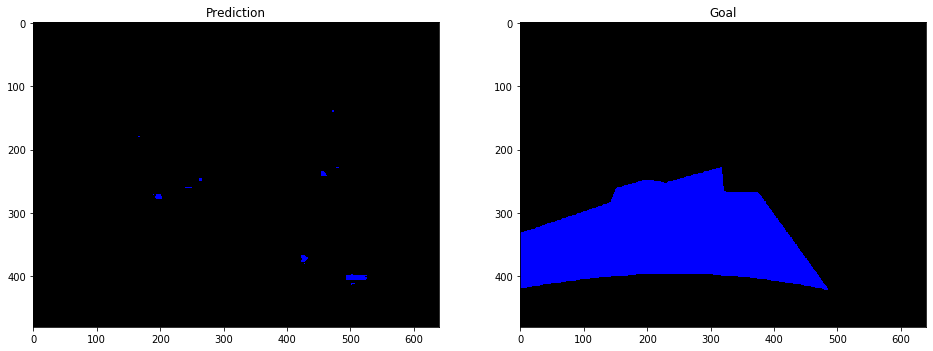

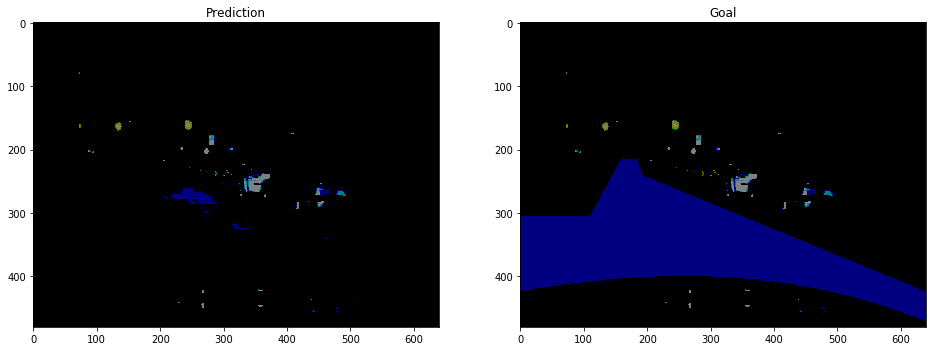

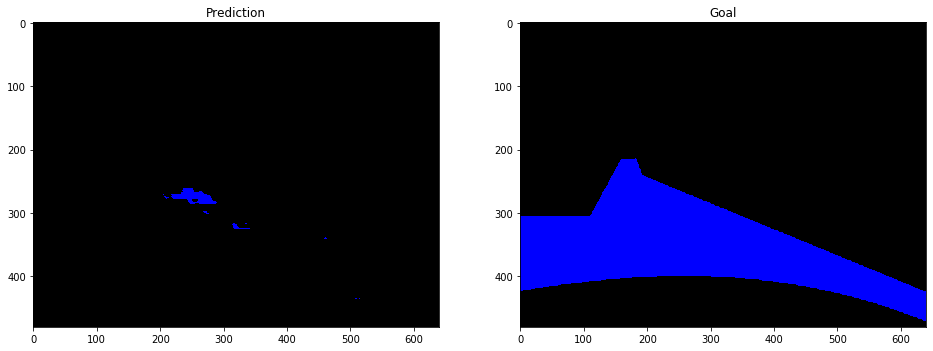

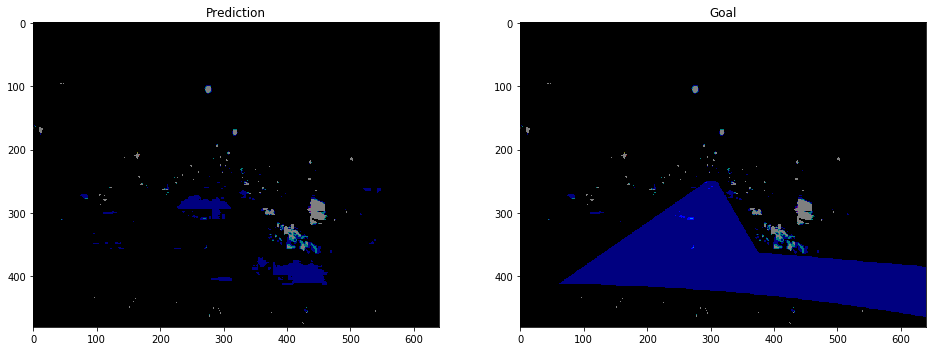

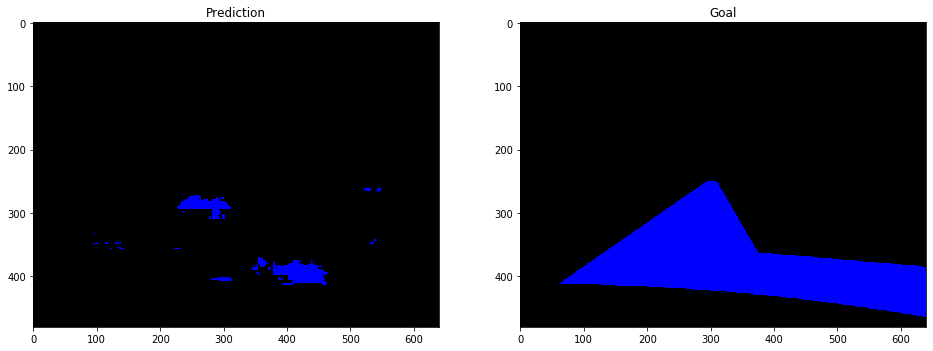

In [126]:
img_pre_tes(1)
img_pre_tes(2)
img_pre_tes(3)
img_pre_tes(4)


#print(x_train_val[0])
#print(img_predicted)


In [ ]:
#model.save_weights('model_weight_haug.ckpt')